# Recommender Case Study

**Imports and configuration**

In [1]:
import os
os.getcwd()

'/Users/kylecaron/Desktop/movie_recommender/notebooks'

In [2]:
import os
os.chdir('..')
from src.util import *
from src.recommender import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Generate random sample and save train-test .csv files

In [3]:
os.getcwd()

'/Users/kylecaron/Desktop/movie_recommender'

In [4]:
#generate_file_split(pd.read_csv('data/training.csv'),1)

In [5]:
# request_data = train_data.copy()
# request_data.drop('rating', axis=1, inplace=True)
# test_data = train_data.copy()

In [6]:
generate_file_split(random_subset(800000), 0.8)

In [7]:
train_data = pd.read_csv('data/ctrain.csv')
test_data = pd.read_csv('data/ctest.csv')
request_data = pd.read_csv('data/crequests.csv')

# Import KMeans Clustered User Groups and make recommendations by group instead of by user

In [8]:
users = pd.read_csv('data/clustered_users.csv')\
        .drop('Unnamed: 0', axis=1)

In [9]:
#train_set
clust_train = pd.merge(train_data, users, on='user', how='left')
clust_train = clust_train.drop('user', axis=1)
clust_train.columns = ['movie', 'rating', 'user']
clust_train.drop_duplicates(inplace=True)
#request set
clust_request = pd.merge(request_data, users, on='user', how='left')
clust_request = clust_request.drop('user', axis=1)
clust_request.columns = ['movie', 'user']
clust_request.drop_duplicates(inplace=True)

In [10]:
reco_instance = MovieRecommender()
fit_model = reco_instance.fit(clust_train)

In [11]:
clust_predictions = reco_instance.transform(clust_request,cluster=False)
clust_predictions.columns = ['movie', 'cluster', 'cluster_rating']

#adjust cluster predictions to fit similar distribution to training data
c2 = clust_predictions.copy()
#c2.cluster_rating = c2.cluster_rating.apply(lambda x: x+1 if x < 4 else np.ceil(x))
c2.cluster_rating = c2.cluster_rating.apply(lambda x: x+1 if x < 4 else np.ceil(x))

In [12]:
#ignore adjustment made above, made RMSE worse
clust_predictions.to_pickle('data/predicted_cluster_ratings')

# Evaluate by filling with clustered data

In [13]:
cluster_ratings = pd.read_pickle('data/predicted_cluster_ratings')

In [14]:
train_data = pd.read_csv('data/training.csv')
request_data = train_data.drop(['rating', 'timestamp'], axis=1)
test_data = pd.read_csv('data/testing.csv')

In [15]:
len(train_data.movie.unique())

3662

In [16]:
len(set(test_data.movie.unique())- set(train_data.movie.unique()))

44

In this current train-test-split, there are 44 movies in the test set not present in the training set

### Fill in missing user data with cluster ratings

In [17]:
users_wo_ratings = set(users.user.unique())-set(train_data.user.unique())
user_clusters = pd.merge(users, cluster_ratings, how='left', 
                         on='cluster').rename(
    columns={'cluster_rating':'rating'})
user_clusters.drop_duplicates(inplace=True)

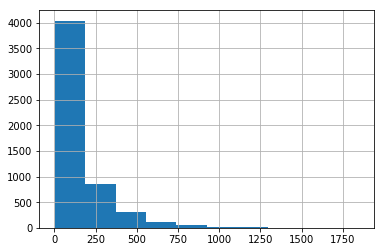

In [18]:
train_data.user.value_counts().hist()

In [19]:
print('Mean: {}'.format(np.mean(train_data.user.value_counts())))
print('Median: {}'.format(np.median(train_data.user.value_counts())))

Mean: 148.17558807186515
Median: 86.0


Users on average have rated 148 movies each. However, the graph is skewed, so median is a better interpretation of the center of this distribution.

### The following code fills in random ratings for new users based on the clusters they belong to

For each new user, they are assigned a cluster based on their demographic data, and 86 (the median) random ratings of the cluster they belong to are assigned to them.

In [20]:
train_adjusted = train_data.copy()
for user in users_wo_ratings:
    mask = (user_clusters['user'] == user)
    subset = user_clusters.loc[mask,['movie','rating', 'user']]
    sample_from_subset = subset.sample(
        int(np.median(train_data.user.value_counts())))
    train_adjusted = pd.concat([train_adjusted, sample_from_subset])


/Users/kylecaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [21]:
len(train_data)

800000

In [22]:
len(train_adjusted)

855126

# Evaluate without clustered data

In [23]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

### Fit recommender model

In [35]:
reco_instance = MovieRecommender()
fit_model = reco_instance.fit(train_data)

### Generate rating predictions

In [36]:
predictions_unclustered = reco_instance.transform(test_data, cluster=False)

In [37]:
rec_evaluator_unclustered = RecoRegressionEvaluation(
    labelCol="actualrating", predictionCol="rating")

rec_score_unclusted = rec_evaluator_unclustered.evaluate(
    predictions_unclustered)

print(rec_score_unclusted)

evaluate based on: actualrating, rating
3.649750743827708


# Evaluate model with clustered data

Look at 5% of most highly predicted movies for each user.
        Return the average actual rating of those movies.

### Fit recommender model

In [57]:
reco_instance = MovieRecommender()
fit_model = reco_instance.fit(train_adjusted)
predictions = reco_instance.transform(test_data)

### Generate rating predictions

In [58]:
rec_evaluator = RecoRegressionEvaluation(labelCol="actualrating",
                                       predictionCol="rating")

rec_score = rec_evaluator.evaluate(predictions)

print(rec_score)

evaluate based on: actualrating, rating
4.292578849721707
